# Everything Image Matching

## Why this notebook exists

I want to expand my horizon as most of my day-to-day ML work is very basic and general. So I decided to try to really dive deep into something completely new that also seemed somewhat manageable. So in order to test what I've learnt so far, I've decided to create a notebook covering mostly everything I know.

**Here is an overview of the notebook:**
- Starts from absolute scratch.
- Shows progressively stronger methods for every stage of an image-matching pipeline, with thorough descriptions and comments throughout.
- Keeps the tone casual - I'm basically learning along with you.
- Finishes with a submission that uses the methods I've found to yield what seems to be the best results.

## 1 Notebook Setup

### 1.1 Core imports

In [2]:
# Standard library imports, nothing super fancy yet
import os, sys, itertools, math
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import cv2                  # OpenCV for image processing
import networkx as nx       # Graph library

**OpenCV:**
- Feature detection
- Descriptor matching
- Epipolar gemoetry

**networkx:**
- Build & cluster an image-similarity graph

### 1.3 Path constants & helper functions

In [11]:
ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR / 'data'
TRAIN_DIR = DATA_DIR / 'train'
OUTPUT_DIR = ROOT_DIR / 'output'

print(f"ROOT_DIR: {ROOT_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"TARIN_DIR: {TRAIN_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

ROOT_DIR: /Users/alfei-sabo/DS/image_matching
DATA_DIR: /Users/alfei-sabo/DS/image_matching/data
TARIN_DIR: /Users/alfei-sabo/DS/image_matching/data/train
OUTPUT_DIR: /Users/alfei-sabo/DS/image_matching/output


In [ ]:
# Helper to preview a handful of images
from PIL import Image

def show_images_grid(paths, cols=5, figsize=(20, 20)):
    """Display images in a scroll-stopping horizontal grid"""
    plt.figure(figsize=figsize)
    for i, p in enumerate(paths):
        print(f"Image {i}: {p}")
        img = Image.open(p) # Open image with PIL
        plt.subplot(1, cols, i+1)
        plt.imshow(img) # Display image
        plt.axis('off')
        plt.title(p.name[:15] + ('...' if len(p.name) > 15 else ''))
    plt.show()

### 1.4 Quick peek at one dataset

fbk_vineyard: 163 images -> showing first 5
Image 0: /Users/alfei-sabo/DS/image_matching/data/train/fbk_vineyard/vineyard_split_1_frame_0900.png
Image 1: /Users/alfei-sabo/DS/image_matching/data/train/fbk_vineyard/vineyard_split_1_frame_0905.png
Image 2: /Users/alfei-sabo/DS/image_matching/data/train/fbk_vineyard/vineyard_split_1_frame_0910.png
Image 3: /Users/alfei-sabo/DS/image_matching/data/train/fbk_vineyard/vineyard_split_1_frame_0915.png
Image 4: /Users/alfei-sabo/DS/image_matching/data/train/fbk_vineyard/vineyard_split_1_frame_0920.png


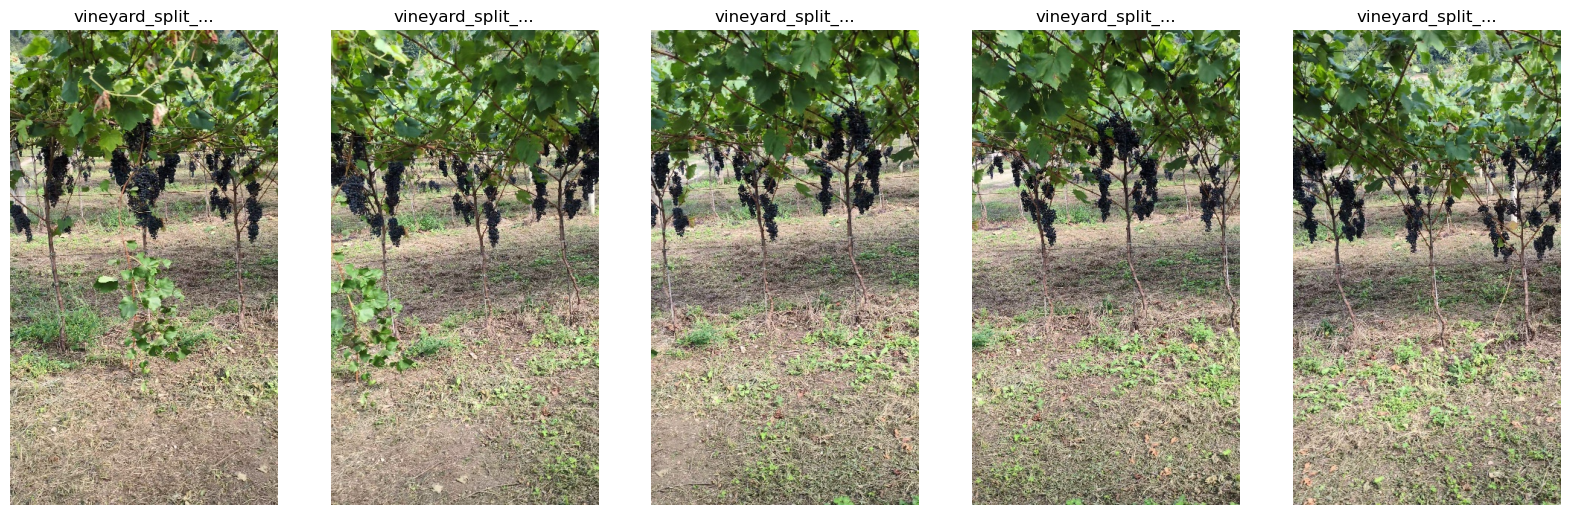

In [18]:
# Pick a small-ish training folder for sanity-check visuals
demo_dataset = 'fbk_vineyard'
demo_dir = TRAIN_DIR /demo_dataset
demo_images = sorted(demo_dir.glob('*.png'))
print(f'{demo_dataset}: {len(demo_images)} images -> showing first {len(demo_images[:5])}')
show_images_grid(demo_images[:5])

## 2 A Bird's-Eye Road-map of Image Matching

> **Skp-ahead option:** If you're already comfy with the big picture, skip ahead to section 3. Everything below will be re-explained in context later. But, spending five minutes here gives you a mental GPS for the rest of the journey.

### 2.1 The pipeline in one picture

📸 raw images → 🧭 keypoint detection → 🧩 descriptor extraction → 🔗 pairwise matching
              → 📐 geometric verification (RANSAC) → 🌐 similarity graph
              → 🤝 clustering & outlier filtering → 🔲 (optional) pose / SfM
              → 📄 submission CSV

### 2.2 Stage-by-stage

| Stage | Why it exists | Basic methods | Fancy upgrades |
|-------|---------------|---------------|----------------|
| Keypoint detection | Find repeatable interest points that survive scale & viewpoint changes | ORB corners, DoG (SIFT), non-linear diffusion (AKAZE) | Learned points (SuperPoint) |
| Descriptor extraction | Turn each point's neighbourhood into a vector so two views can be compared | Binary BRIEF, 128-D SIFT | NetVLAD / DELF global descriptors |
| Matching | Decide which descriptors correspond | Brute-Force or FLANN + Lowe's ratio test | Graph-cut matching, SuperGlue |
| Geometric verification | Throw away accidental matches that don't obey projective geometry | Homography & Fundamental matrix RANSAC | MAGSAC++, PROSAC, USAC |
| Similarity graph | Graph with edges between nodes representing the "evidence" of two images being from the same scene | Simple threshold, adaptive percentile | Edge weighting via learned similarity |
| Clustering | Group images into distinct scenes | Connected components, Louvain, Spectral, DBSCAN | Graph neural nets for partitioning |
| Outlier detection | Discard images that belong to no scene | Degree/srength filter | One-class SVM on global features |
| Pose / SfM | Recover 3-D & camera poses (boosts Kaggle score) | Essential-atrix chaining | Full COLMAP bundle adjust |

### 2.3 How all these parts tak to each other

1. **Local features** gives us a language to compare any two images.
2. **Matching** builds tentative correspondences; RANSAC confirms which are geometrically plausible.
3. **Graph** globalises all pairwise connections, with edge-weights showing how likely the pair is to be from the same scene.
4. **Clusters** are created based on these edges and weights based on chosen method for clustering.
4. **SfM** triangulates 3-D points without being confused by unrelated photos if clusters are "pure".

### 2.4 Tiney code demo: basic matching of two images

Good matches: 10


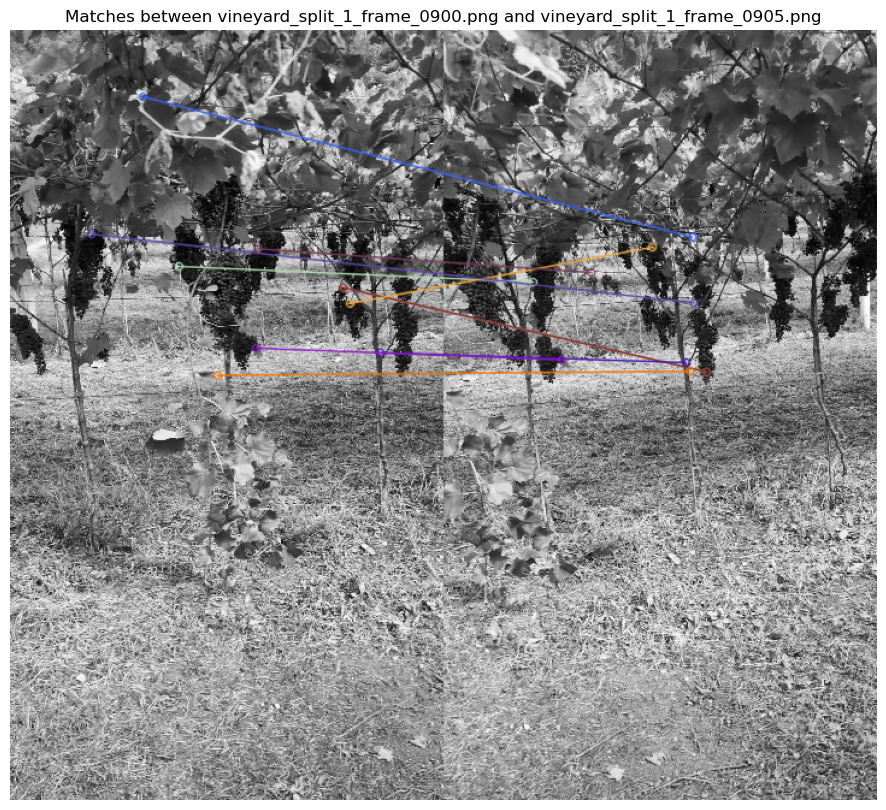

In [23]:
# Select two demo images
a, b = demo_images[0], demo_images[1]

# ORB detector
orb = cv2.ORB_create(nfeatures=1000)

# Detect keypoints and compute descriptors
kp1, des1 = orb.detectAndCompute(cv2.imread(a, cv2.IMREAD_GRAYSCALE), None)
kp2, des2 = orb.detectAndCompute(cv2.imread(b, cv2.IMREAD_GRAYSCALE), None)

# Find matches using the brute-force matcher
matches = cv2.BFMatcher(cv2.NORM_HAMMING).knnMatch(des1, des2, k=2)

# Lowe ratio filter
good = [m for m, n in matches if m.distance < 0.75 * n.distance]

print(f'Good matches: {len(good)}')

# Draw matches
img1 = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(b, cv2.IMREAD_GRAYSCALE)
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 10))
plt.imshow(img_matches)
plt.axis('off')
plt.title(f'Matches between {a.name} and {b.name}')
plt.show()

*Don't worry about the details, this is just to show the vibe of an image-matching primitive. Section 4 will formalise everything*

### 2.5 Where beginners often stumble (and how we'll avoid it)

* **Matching ≠ clustering:** Great matches can still produce a messy global graph; we'll visualise graphs early to debug.
* **Planar vs non-planar scenes:** Using only homographies breaks on 3-D structures, we'll introduce fundamental matrices too.
* **Thresholds everywhere:** We'll build an adaptive edge threshold to cut hand-tuning time.